# 3. Luther – Regression

## Imports & Versions

In [65]:
import numpy as np
import pandas as pd
# import requests
# from bs4 import BeautifulSoup
import pickle
from datetime import datetime, timedelta
import time
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.externals import joblib
# joblib.dump(lr, 'data/survey_sk_model.pkl')
import statsmodels.api as sm
import statsmodels.formula.api as smf

% matplotlib inline

# from selenium import webdriver
# from selenium.webdriver.common.keys import Keys
# import os
# chromedriver = "/Applications/chromedriver"
# os.environ["webdriver.chrome.driver"] = chromedriver

In [2]:
list_of_imports = [('Numpy', np), 
                   ('Pandas', pd), 
#                   ('Beautiful Soup', BeautifulSoup), 
#                    ('Selenium', webdriver)
                  ]

for mod in list_of_imports:
    print(f"{mod[0]}: {mod[1].__version__}")

print("Python:", sys.version)

Numpy: 1.13.1
Pandas: 0.20.3
Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


In [3]:
with open('../data/AAL_clean.pkl', 'rb') as pf: 
    AAL = pickle.load(pf)

## What to Include and How...

In [4]:
AAL.describe()

,lateness_land,lateness_arr,taxi_act,taxi_sch,hour_of_day,q_of_day,weekday
count,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000,1685.000000
mean,7.375074,-10.915134,16.528783,34.818991,14.434421,1.975074,2.785757
std,29.929697,20.120493,8.125203,20.884676,4.350581,0.768653,1.981455
min,-45.000000,-58.000000,0.000000,0.000000,8.000000,1.000000,0.000000
25%,-19.000000,-25.000000,11.000000,14.000000,11.000000,1.000000,1.000000
50%,8.000000,-14.000000,16.000000,40.000000,14.000000,2.000000,3.000000
75%,27.000000,0.000000,19.000000,55.000000,18.000000,3.000000,4.000000
max,100.000000,51.000000,68.000000,77.000000,23.000000,3.000000,6.000000


In [51]:
AAL.shape

(1685, 20)

Next, I'll split off the target column and possible feature columns.

In [49]:
AAL_sub = AAL.filter(['lateness_arr', 
                      'taxi_sch', 
                      'weekday', 
                      'hour_of_day', 
                      'q_of_day'
                     ]
                    )

...then inspect with corr / pair plot.

In [50]:
AAL_sub.corr()

,lateness_arr,taxi_sch,weekday,hour_of_day,q_of_day
lateness_arr,1.000000,0.107158,-0.144172,0.039277,0.046443
taxi_sch,0.107158,1.000000,-0.030757,-0.019028,-0.005090
weekday,-0.144172,-0.030757,1.000000,-0.028393,-0.035479
hour_of_day,0.039277,-0.019028,-0.028393,1.000000,0.933375
q_of_day,0.046443,-0.005090,-0.035479,0.933375,1.000000


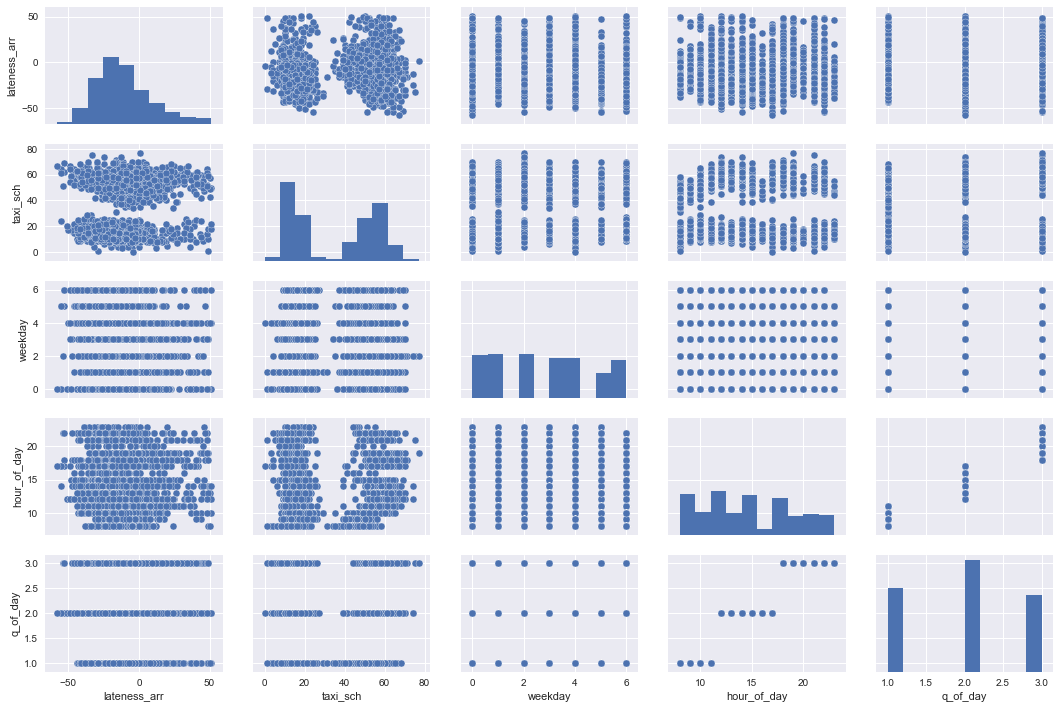

In [10]:
sns.pairplot(AAL_sub, size=2, aspect=1.5);

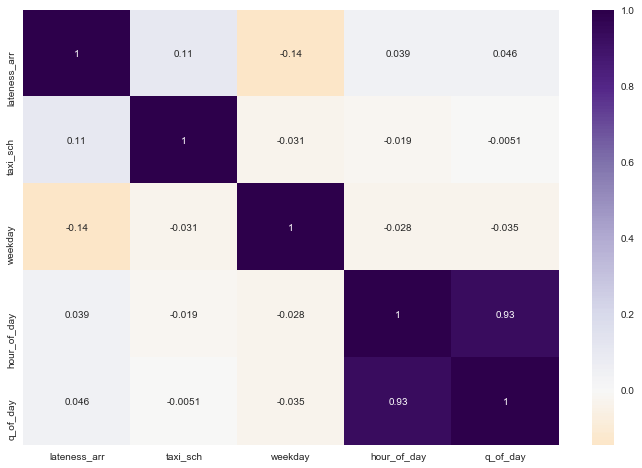

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(AAL_sub.corr(), 
            cmap="PuOr", # "RdBu" "PuOr"
            center=0.0, 
            annot=True);

#plt.savefig('../viz/heatmap2.png', dpi=200, bbox_inches = 'tight')

Very weak negative correlation spotted with **weekday** and **lateness_arr**. Colinearity found with **hour_of_day** and **q_of_day** is not surprising, as the former is a roughly a subset of the latter. Thus, it would be best to use one or the other when modeling.

Now, convert categorical vars to dummy cols. Starting with a complete set:

In [36]:
AAL_sub_twhq = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

In [37]:
AAL_twhq = (pd
            .get_dummies(AAL_sub_twhq, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
                             'q_of_day', 
#                             'f_num'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [38]:
AAL_twhq.columns

Index(['lateness_arr', 'taxi_sch', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'hour_of_day_9',
       'hour_of_day_10', 'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13',
       'hour_of_day_14', 'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17',
       'hour_of_day_18', 'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21',
       'hour_of_day_22', 'hour_of_day_23', 'q_of_day_2', 'q_of_day_3'],
      dtype='object')

In [39]:
AAL.q_of_day.value_counts()

2    689
1    519
3    477
Name: q_of_day, dtype: int64

Since there are no flights scheduled to land between midnight and 6am, there are no zeros for the q_of_day (quarter of day) column, and thus only two dummies for that column. All others appear as expected.

#### Heat Map of Scheduled Taxi Time, Weekday, Hour of Day, Quarter of Day

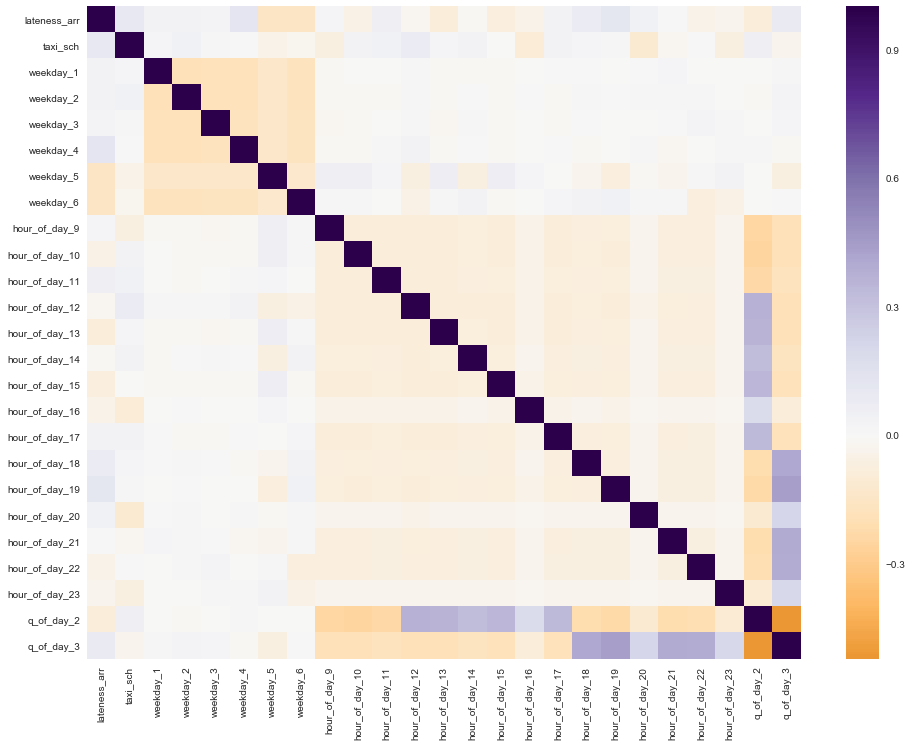

In [40]:
plt.figure(figsize=(16,12))
sns.heatmap(AAL_twhq.corr(),
            center=0.0,
            cmap="PuOr"
           );

## Let's Get To Regression

A few functions to expedite the process...

In [29]:
def quick_lr(X, y, random_state=23):
    """
    Test/Train splits at 20/80, fits a LR to all features in X_tr,
    then predicts based on X_ts.
    """
    lr = LinearRegression()
    X_tr, X_ts, y_tr, y_ts = tts(X, y, test_size=0.20, random_state=random_state)
    lr.fit(X_tr, y_tr)
    y_hat = lr.predict(X_ts)
    
    MSE = mean_squared_error(y_ts, y_hat)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_ts, y_hat)
    r2 = lr.score(X_ts, y_ts)
    ar2 = adj_r2(r2, X_ts.shape[0], X_ts.shape[1])
                              
    print("R-squared (full):", lr.score(X, y))
    print("R-squared (test):", r2)
    print("Adj R-Squared (test):", ar2)
    # print("MSE:", MSE)
    print("RMSE:", RMSE)
    print("MAE:", MAE)
    
    return y_hat, y_ts

In [30]:
def adj_r2(rsquare, num_data, num_features):
    temp = (1-rsquare)*(num_data-1)
    temp = temp/(num_data-num_features-1)
    temp = 1 - temp
    return temp

In [124]:
def quick_yvy_scatter(ys):
    """
    Quick/dirty scatterplot of predicted v. real targets.
    """
    y_hat, y_act = ys
    plt.figure(figsize=(10,6))
    plt.scatter(y_hat, y_act)
    plt.xlabel("Predicted Targets")
    plt.ylabel("Actual Targets")

### 1. Taxi Time, Weekday, Quarter of Day

In [125]:
AAL_sub_twq = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_twq = (pd
            .get_dummies(AAL_sub_twq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day' 
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0765902767155
R-squared (test): 0.089876732317
Adj R-Squared (test): 0.0648274680688
RMSE: 18.9203893928
MAE: 14.5604510851


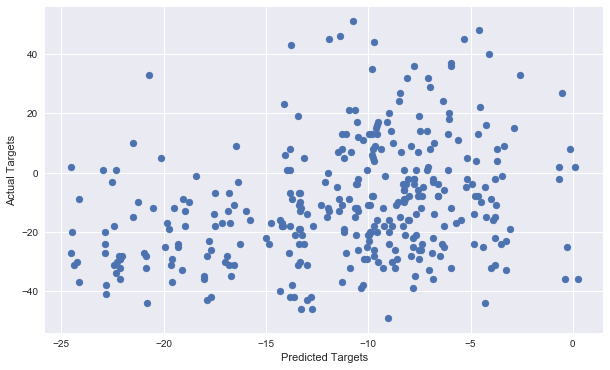

In [126]:
y_twq = AAL_twq.iloc[:, 0]
X_twq = AAL_twq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twq, y_twq, random_state=23))

### 2. Taxi Time, Weekday, Hour of Day

In [105]:
AAL_sub_twh = (AAL_sub
 .filter(['lateness_arr',
          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

AAL_twh = (pd
            .get_dummies(AAL_sub_twh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.106676434212
R-squared (test): 0.118400594134
Adj R-Squared (test): 0.0566324828947
RMSE: 18.6215404991
MAE: 14.2122122025


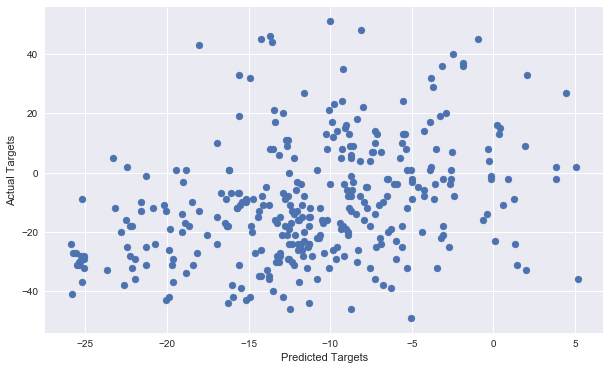

In [106]:
y_twh = AAL_twh.iloc[:, 0]
X_twh = AAL_twh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_twh, y_twh, random_state=23))

### 3. Weekday, Quarter of Day

In [45]:
AAL_sub_wq = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
#          'hour_of_day',
          'q_of_day',
#          'f_num'
         ])
           )

AAL_wq = (pd
            .get_dummies(AAL_sub_wq, 
                         columns=[
                             'weekday', 
#                             'hour_of_day',
                             'q_of_day'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.0666668782348
R-squared (test): 0.0648092431733
Adj R-Squared (test): 0.041999712519
RMSE: 19.1791812913
MAE: 14.8337373685


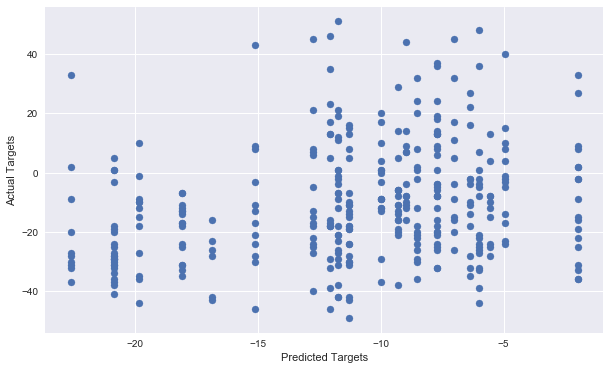

In [46]:
y_wq = AAL_wq.iloc[:, 0]
X_wq = AAL_wq.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wq, y_wq, random_state=23))

### 4. Weekday, Hour of Day

In [47]:
AAL_sub_wh = (AAL_sub
 .filter(['lateness_arr',
#          'taxi_sch',
          'weekday',
          'hour_of_day',
#          'q_of_day',
#          'f_num'
         ])
           )

AAL_wh = (pd
            .get_dummies(AAL_sub_wh, 
                         columns=[
                             'weekday', 
                             'hour_of_day',
#                             'q_of_day'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

R-squared (full): 0.097754257476
R-squared (test): 0.0937099960372
Adj R-Squared (test): 0.0332906624396
RMSE: 18.8805028338
MAE: 14.470554223


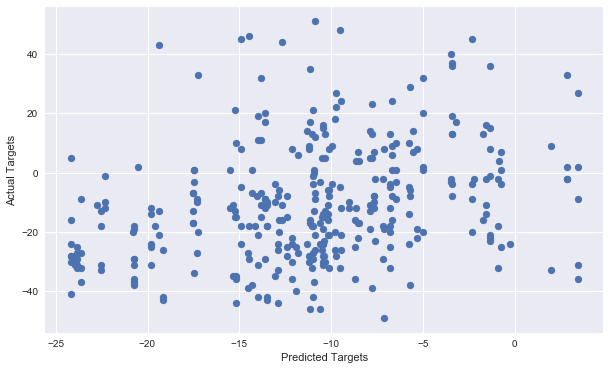

In [55]:
y_wh = AAL_wh.iloc[:, 0]
X_wh = AAL_wh.iloc[:, 1:]

quick_yvy_scatter(quick_lr(X_wh, y_wh, random_state=23))

Nothing provided particualarly promising scores, but will try cross-validation with each of these combinations.

## Cross-Validation

**Abbreviations:** cvs = cross_val_score(), cvp = cross_val_predict()

In [113]:
def coarse_grid_search(feat_arrs, folds=5, rs=23):
    """
    Feed list of possible feature arrays (X,y) tuple pais and fold number, 
    spit out RMSE for each fold and the mean RMSE for all.
    """
    
    for n, pair in enumerate(feat_arrs):
        lr = LinearRegression()
        X, y = pair
        nmse_scores = cvs(lr, X, y, 
                          cv=KFold(n_splits=folds, shuffle=True, random_state=rs),
                          scoring='neg_mean_squared_error'
                         )
        rmse_scores = [np.sqrt(-1 * i) for i in nmse_scores]
        avg_rmse = sum(rmse_scores) / folds
        
        print("\n*** Model", n+1)
        print(rmse_scores)
        print("Average RMSE:", avg_rmse)

In [111]:
feature_arrays = [(X_twq, y_twq),
                  (X_twh, y_twh),
                  (X_wq, y_wq),
                  (X_wh, y_wh)
                 ]

In [121]:
coarse_grid_search(feature_arrays, folds=5, rs=23)


*** Model 1
[18.920389392787261, 18.885750543672707, 20.056811316687789, 19.548930042819183, 19.736094761986116]
Average RMSE: 19.4295952116

*** Model 2
[18.621540499083075, 18.503397942875722, 20.548337407582832, 19.351304785037488, 19.34453181719952]
Average RMSE: 19.2738224904

*** Model 3
[19.17918129125195, 19.05385625614154, 20.171568512505107, 19.647490162281819, 19.485168309145685]
Average RMSE: 19.5074529063

*** Model 4
[18.880502833831912, 18.662123731359994, 20.661927327475688, 19.431558722397657, 19.130265182903404]
Average RMSE: 19.3532755596


All four feature sets performed about as poorly, though the two that included Hour of Day as opposed to Quarter (2 & 4) performed slightly better than the others, with 2 having the best score, an average RMSE of 19.27. Because of all the additional features, its adjusted-R<sup>2</sup> in the above trials was 0.057, 0.01 under the 0.065 of model 1.

In this case, where none of the models are showing any predictive promise, average RMSE ranges from 19.27 to 19.51, and adjusted-R<sup>2</sup> ranges from 0.033 to 0.065, it is incredibly difficult to pick one model that is arguably any better than another. Were this a professional project of consequence, I would go back to square one and try to collect other features that might show a stronger correlation with lateness. 

But for the sake of exercise, in this case, I'll go with Model 2, given it's marginally better RMSE score.

#### Training the final model...

In [134]:
lr_final = LinearRegression()
lr_final.fit(X_twh, y_twh)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

And it's now ready to see some wild data.

## Model Meets Test Set

In [139]:
with open('../data/AAL_test.pkl', 'rb') as pf: 
    AAL_test_full = pickle.load(pf)

Boil down to the same format as the training set, pull out features and target:

In [143]:
AAL_test_sub = (AAL_test_full
    .filter([
        'lateness_arr', 
        'taxi_sch', 
        'weekday', 
        'hour_of_day',
        'q_of_day'
    ])
               )

AAL_test_twh = (AAL_test_sub
    .filter([
        'lateness_arr',
        'taxi_sch',
        'weekday',
        'hour_of_day'
#       'q_of_day'
    ])
               )

AAL_test = (pd
            .get_dummies(AAL_test_twh, 
                         columns=[
                             'weekday', 
                             'hour_of_day'
#                             'q_of_day'
                         ], drop_first=True)
            .reset_index(drop=True)
           )

In [144]:
AAL_test.head()

,lateness_arr,taxi_sch,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_of_day_9,hour_of_day_10,...,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23
0,-29,17,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-24,10,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-25,10,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-5,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,-17,8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [145]:
y_test = AAL_test.iloc[:, 0]
X_test = AAL_test.iloc[:, 1:]

### The Model Predicts

In [146]:
y_hat = lr_final.predict(X_test)

In [147]:
MSE_test = mean_squared_error(y_test, y_hat)
RMSE_test = np.sqrt(MSE_test)
print("RMSE:", RMSE_test)

RMSE: 14.5141242241


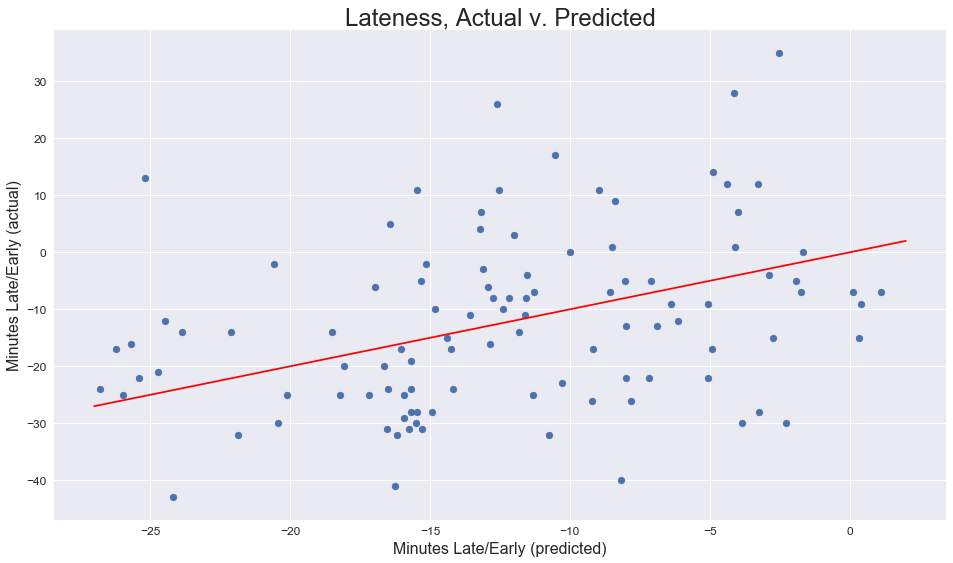

In [170]:
line = np.linspace(-27, 2, 50)

plt.figure(figsize=(16,9))
plt.scatter(y_hat, y_test)
plt.plot(line, line, 'r-')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Minutes Late/Early (predicted)", fontsize=16)
plt.ylabel("Minutes Late/Early (actual)", fontsize=16)
plt.title("Lateness, Actual v. Predicted", fontsize=24);

# plt.savefig('../viz/test_line.png', dpi=200, bbox_inches = 'tight')

Not so good...

### Can it at least beat the dummy??

In [158]:
dr = DummyRegressor()

In [159]:
dr.fit(X_twh, y_twh)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [160]:
y_twh.mean()

-10.91513353115727

In [162]:
y_dummy = dr.predict(X_test)

In [171]:
MSE_dummy = mean_squared_error(y_test, y_dummy)
RMSE_dummy = np.sqrt(MSE_dummy)
print("RMSE (model): {0:.2f}".format(RMSE_test))
print("RMSE (dummy): {0:.2f}".format(RMSE_dummy))
print("Difference (model-dummy): {0:.2f}".format(RMSE_test - RMSE_dummy))

RMSE (model): 14.51
RMSE (dummy): 15.26
Difference (model-dummy): -0.74


Beat by 0.74!!